# Person Re-ID with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import json
import time

In [2]:
from vbranch.datasets.reid import TripletDataGenerator, TestingDataGenerator
from vbranch.applications import SimpleCNNLarge, ResNet50, DenseNet121
from vbranch.callbacks import reid_acc
from vbranch.losses import triplet
from vbranch.utils import *

Using TensorFlow backend.


In [3]:
# from keras.applications import DenseNet121 as KerasDenseNet121
# from keras.backend import learning_phase

In [4]:
SAVE = True
MODEL_ID = 1
ARCHITECTURE = 'densenet'
DATASET = 'market'
NUM_BRANCHES = 2
SHARED_FRAC = 0.25

EPOCHS = 250
STEPS_PER_EPOCH = 100
T_0 = 150
OUTPUT_DIM = 128
# IMG_DIM = (256, 128, 3)
IMG_DIM = (128, 64, 3)

In [5]:
if not os.path.isdir('models'):
    os.system('mkdir models')

if NUM_BRANCHES == 1:
    model_name = '{}-{}-dim{}_{:d}'.format(DATASET, ARCHITECTURE, IMG_DIM[0], MODEL_ID)
else:
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}-dim{}_{:d}'.format(DATASET, ARCHITECTURE,
                                        NUM_BRANCHES, SHARED_FRAC, IMG_DIM[0], MODEL_ID)
model_path = os.path.join('models', model_name)
print(model_path)

models/vb-market-densenet-B2-S0.25-dim128_1


## Load Data

In [15]:
P, K = 18, 4
train_generator = TripletDataGenerator(DATASET, 'train', 
                                       P=P, K=K,
                                       preprocess=ARCHITECTURE, 
                                       img_dim=IMG_DIM, 
                                       pose_orientation=2)

TripletDataGenerator CONFIG
Dataset:	 market
Split:		 train
Preprocess:	 densenet
Dimension:	 (128, 64, 3)
Crop:		 False
Flip:		 True
Flatten:	 True
Labels:		 False


In [16]:
len(train_generator.files_arr)

4073

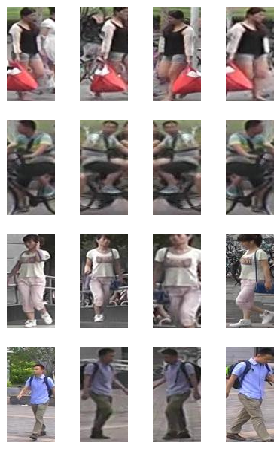

In [7]:
batch = train_generator.sample(4, 4, flatten=False, 
                             preprocess=False, 
                             img_dim=IMG_DIM)
plt.figure(figsize=(5, 8))
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, 4*i+j+1)
        plt.imshow(batch[i, j].squeeze(), cmap=plt.cm.gray)
        plt.axis('off')
plt.show()

In [8]:
batch.min(), batch.max()

(0, 255)

## Build Model

In [9]:
inputs, train_init_op, test_init_op = get_data_iterator_from_generator(train_generator, 
                                                                  (None,)+IMG_DIM, 
                                                                  n=NUM_BRANCHES)
print(inputs)

W0727 16:05:53.920702 140417217025792 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:184: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 16:05:53.962524 140417217025792 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the depre

[<tf.Tensor 'input_1:0' shape=(?, 128, 64, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 128, 64, 3) dtype=float32>]


In [10]:
lr = tf.placeholder('float32', name='lr')
lr_scheduler = lr_exp_decay_scheduler(0.0003, T_0, EPOCHS, 0.001)

name = 'model'

with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    if ARCHITECTURE == 'simple':
        model = SimpleCNNLarge(inputs, OUTPUT_DIM, name=name, 
                               shared_frac=SHARED_FRAC)
    elif ARCHITECTURE == 'resnet':
        model, assign_ops = ResNet50(inputs, OUTPUT_DIM, name=name, 
                                     shared_frac=SHARED_FRAC, 
                                     weights='imagenet')
    elif ARCHITECTURE == 'densenet':
        model, assign_ops = DenseNet121(inputs, OUTPUT_DIM, name=name, 
                                     shared_frac=SHARED_FRAC, 
                                     weights='imagenet')
    
    start = time()
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)

    # Compile model
    model.compile(optimizer, triplet(P,K, margin='soft'), 
                  train_init_op, test_init_op, 
                  callbacks={'acc' : reid_acc(DATASET, NUM_BRANCHES, 
                                              preprocess=ARCHITECTURE, 
                                              buffer=1000, img_dim=IMG_DIM)},
                  schedulers={'lr:0': lr_scheduler},  
                  assign_ops=assign_ops)
    print(f'Compile time: {time()-start} s')

W0727 16:05:54.022148 140417217025792 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/slim.py:169: The name tf.get_variable_scope is deprecated. Please use tf.compat.v1.get_variable_scope instead.

W0727 16:05:54.022859 140417217025792 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/slim.py:172: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0727 16:05:54.024170 140417217025792 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/slim.py:172: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0727 16:05:54.024856 140417217025792 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/slim.py:175: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 16:05:54.109537 140417217025792 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/layers/pooling.py:56: The name tf.nn.max_pool

Loading weights for DenseNet121...


W0727 16:06:15.276425 140417217025792 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Compile time: 136.92793893814087 s


In [11]:
model.summary()

i    Layer name                      Output shape                      Num param  Inbound               
--------------------------------------------------------------------------------------------------------
     Input                           [None,128,64,3]                                                    
--------------------------------------------------------------------------------------------------------
     Input                           [None,128,64,3]                                                    
--------------------------------------------------------------------------------------------------------
0    zero_pad (ZeroPadding2D)        [None,134,70,3]                   0          input                 
                                     [None,134,70,3]                                                    
--------------------------------------------------------------------------------------------------------
1    conv1/conv (Conv2D)             [None,64,32,16] [N

In [12]:
# with TFSessionGrow() as sess:
#     keras_model = KerasDenseNet121(weights='imagenet', input_shape=(128, 64, 3), include_top=False)
#     n = 425
#     ip = np.random.randn(1, 128, 64, 3)
#     keras_layer = keras_model.layers[n+1]
#     print(keras_layer.name)
#     keras_output = sess.run(keras_layer.output, feed_dict={keras_model.input:ip, 
#                                                            learning_phase():1})
#     sess.run(tf.global_variables_initializer())
#     sess.run(assign_ops)
#     print(model.layers[n].name)
#     sess.run(['test_init_op_{}'.format(i+1) for i in range(NUM_BRANCHES)], 
#              feed_dict={'x:0':ip, 'batch_size:0':len(ip)})
#     model_output = sess.run(list(model.layers[n].output))

In [13]:
# print(keras_output.shape)
# print(model_output[0][0].shape)

In [14]:
# keras_output[0][0,0, :32]

In [15]:
# model_output[0][0][0, 0,0]

In [16]:
print(model.output)

[<tf.Tensor 'model/output/vb1/output:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'model/output/vb2/output:0' shape=(?, 128) dtype=float32>]


In [17]:
# model.layers[427].get_weights()

In [18]:
model.losses

{'loss_1': <tf.Tensor 'model/loss_1:0' shape=() dtype=float32>,
 'loss_2': <tf.Tensor 'model/loss_2:0' shape=() dtype=float32>}

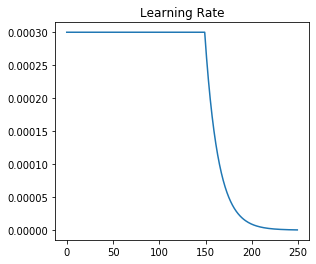

In [19]:
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
# beta1_steps = [beta1_sched(e + 1) for e in range(EPOCHS)]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lr_steps)
plt.title('Learning Rate')

# plt.subplot(1,2,2)
# plt.plot(beta1_steps)
# plt.title('Beta 1')

plt.show()

In [20]:
# lr_steps[149]

In [21]:
history = model.fit(EPOCHS, STEPS_PER_EPOCH, log_path=model_path if SAVE else None, 
                    call_step=10, verbose=1)

Epoch 1/250
100/100 [==============================] - 608s 6s/step - lr:0: 3.0000e-04 - loss_1: 1264.6100 - loss_2: 1358.5461
Epoch 2/250
100/100 [==============================] - 89s 892ms/step - lr:0: 3.0000e-04 - loss_1: 568.7301 - loss_2: 694.4441
Epoch 3/250
100/100 [==============================] - 89s 893ms/step - lr:0: 3.0000e-04 - loss_1: 333.9082 - loss_2: 387.2048
Epoch 4/250
100/100 [==============================] - 89s 893ms/step - lr:0: 3.0000e-04 - loss_1: 206.7325 - loss_2: 250.5692
Epoch 5/250
100/100 [==============================] - 89s 894ms/step - lr:0: 3.0000e-04 - loss_1: 158.8277 - loss_2: 198.2703
Epoch 6/250
100/100 [==============================] - 90s 901ms/step - lr:0: 3.0000e-04 - loss_1: 121.4588 - loss_2: 149.5774
Epoch 7/250
100/100 [==============================] - 90s 898ms/step - lr:0: 3.0000e-04 - loss_1: 107.3893 - loss_2: 118.9679
Epoch 8/250
100/100 [==============================] - 90s 898ms/step - lr:0: 3.0000e-04 - loss_1: 91.2116 - lo

Epoch 41/250
100/100 [==============================] - 89s 892ms/step - lr:0: 3.0000e-04 - loss_1: 27.6819 - loss_2: 31.4923
Epoch 42/250
100/100 [==============================] - 89s 895ms/step - lr:0: 3.0000e-04 - loss_1: 26.7112 - loss_2: 26.4627
Epoch 43/250
100/100 [==============================] - 89s 895ms/step - lr:0: 3.0000e-04 - loss_1: 27.7162 - loss_2: 30.4274
Epoch 44/250
100/100 [==============================] - 89s 894ms/step - lr:0: 3.0000e-04 - loss_1: 24.1335 - loss_2: 33.4523
Epoch 45/250
100/100 [==============================] - 89s 892ms/step - lr:0: 3.0000e-04 - loss_1: 24.1861 - loss_2: 34.2977
Epoch 46/250
100/100 [==============================] - 89s 894ms/step - lr:0: 3.0000e-04 - loss_1: 20.8740 - loss_2: 26.8097
Epoch 47/250
100/100 [==============================] - 89s 894ms/step - lr:0: 3.0000e-04 - loss_1: 17.2748 - loss_2: 28.5468
Epoch 48/250
100/100 [==============================] - 89s 893ms/step - lr:0: 3.0000e-04 - loss_1: 16.7657 - loss_2: 

Epoch 81/250
100/100 [==============================] - 99s 994ms/step - lr:0: 3.0000e-04 - loss_1: 21.0733 - loss_2: 18.3017
Epoch 82/250
100/100 [==============================] - 101s 1s/step - lr:0: 3.0000e-04 - loss_1: 22.6981 - loss_2: 15.6820
Epoch 83/250
100/100 [==============================] - 103s 1s/step - lr:0: 3.0000e-04 - loss_1: 22.0198 - loss_2: 17.2999
Epoch 84/250
100/100 [==============================] - 95s 949ms/step - lr:0: 3.0000e-04 - loss_1: 22.5911 - loss_2: 21.3003
Epoch 85/250
100/100 [==============================] - 91s 906ms/step - lr:0: 3.0000e-04 - loss_1: 18.8292 - loss_2: 18.2324
Epoch 86/250
100/100 [==============================] - 91s 906ms/step - lr:0: 3.0000e-04 - loss_1: 16.5783 - loss_2: 20.6158
Epoch 87/250
100/100 [==============================] - 94s 936ms/step - lr:0: 3.0000e-04 - loss_1: 15.1477 - loss_2: 22.5262
Epoch 88/250
100/100 [==============================] - 97s 970ms/step - lr:0: 3.0000e-04 - loss_1: 18.5631 - loss_2: 19.7

Epoch 121/250
100/100 [==============================] - 97s 965ms/step - lr:0: 3.0000e-04 - loss_1: 16.9440 - loss_2: 9.1949
Epoch 122/250
100/100 [==============================] - 98s 981ms/step - lr:0: 3.0000e-04 - loss_1: 15.6759 - loss_2: 12.2088
Epoch 123/250
100/100 [==============================] - 99s 986ms/step - lr:0: 3.0000e-04 - loss_1: 14.2586 - loss_2: 10.8366
Epoch 124/250
100/100 [==============================] - 99s 989ms/step - lr:0: 3.0000e-04 - loss_1: 12.8350 - loss_2: 13.4155
Epoch 125/250
100/100 [==============================] - 99s 985ms/step - lr:0: 3.0000e-04 - loss_1: 15.8073 - loss_2: 12.5575
Epoch 126/250
100/100 [==============================] - 99s 986ms/step - lr:0: 3.0000e-04 - loss_1: 14.9495 - loss_2: 8.7487
Epoch 127/250
100/100 [==============================] - 99s 985ms/step - lr:0: 3.0000e-04 - loss_1: 17.3653 - loss_2: 20.0914
Epoch 128/250
100/100 [==============================] - 99s 986ms/step - lr:0: 3.0000e-04 - loss_1: 14.3055 - lo

Epoch 161/250
100/100 [==============================] - 91s 909ms/step - lr:0: 1.4032e-04 - loss_1: 2.6001 - loss_2: 2.8067
Epoch 162/250
100/100 [==============================] - 90s 904ms/step - lr:0: 1.3095e-04 - loss_1: 1.8234 - loss_2: 2.4811
Epoch 163/250
100/100 [==============================] - 96s 957ms/step - lr:0: 1.2221e-04 - loss_1: 1.6764 - loss_2: 2.0830
Epoch 164/250
100/100 [==============================] - 97s 974ms/step - lr:0: 1.1406e-04 - loss_1: 1.6035 - loss_2: 2.9068
Epoch 165/250
100/100 [==============================] - 98s 978ms/step - lr:0: 1.0644e-04 - loss_1: 2.8246 - loss_2: 2.8879
Epoch 166/250
100/100 [==============================] - 99s 987ms/step - lr:0: 9.9339e-05 - loss_1: 1.3069 - loss_2: 1.6599
Epoch 167/250
100/100 [==============================] - 99s 987ms/step - lr:0: 9.2709e-05 - loss_1: 1.7123 - loss_2: 1.2125
Epoch 168/250
100/100 [==============================] - 99s 985ms/step - lr:0: 8.6521e-05 - loss_1: 1.1068 - loss_2: 1.9034


OSError: [Errno 12] Cannot allocate memory

Process Process-267:
Process Process-268:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gong/anaconda3/lib/python3.6/multiprocessing/managers.py", line 749, in _callmethod
    conn = self._tls.connection
  File "/home/gong/anaconda3/lib/python3.6/multiprocessing/managers.py", line 749, in _callmethod
    conn = self._tls.connection
AttributeError: 'ForkAwareLocal' object has no attribute 'connection'
AttributeError: 'ForkAwareLocal' object has no attribute 'connection'

During handling of the above exception, another exception occurred:


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/gong/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/gong/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/gong/anaconda3/lib/

## Evaluation

In [4]:
with TFSessionGrow() as sess:
    restore_sess(sess, 'models/market-densenet-dim256_1/')
    print(reid_acc(DATASET, NUM_BRANCHES, preprocess=ARCHITECTURE,
                   buffer=1000, img_dim=IMG_DIM, crop=False)(sess))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/market-densenet-dim256_1/ckpt
995 15913
842 3368
Computing gallery embeddings...
15913/15913 [==============================] - 95s 6ms/step
Computing query embeddings...
3368/3368 [==============================] - 21s 6ms/step
Started process...
Started process...
Started process...
Started process...
Elapsed time: 18.550950050354004
{'mAP': 0.6934945495051927, 'rank1': 0.8423397, 'rank5': 0.9403207}


In [4]:
with TFSessionGrow() as sess:
    restore_sess(sess, 'models/market-densenet-dim256_1/')
    print(reid_acc(DATASET, NUM_BRANCHES, preprocess=ARCHITECTURE,
                   buffer=1000, img_dim=IMG_DIM, crop=True)(sess))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/market-densenet-dim256_1/ckpt
995 15913
842 3368
Computing gallery embeddings...
15913/15913 [==============================] - 97s 6ms/step
Computing query embeddings...
3368/3368 [==============================] - 22s 6ms/step
Started process...
Started process...
Started process...
Started process...
Elapsed time: 33.23809599876404
{'mAP': 0.6466024319270626, 'rank1': 0.8111639, 'rank5': 0.9275534}
